In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# ML tools 
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, Conv2D,MaxPooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import InceptionResNetV2
import os
from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [2]:
df_target = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
display(df_target.head(3))
print(df_target.shape)
df_sample = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
display(df_sample.head(3))
print(df_sample.shape)

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5


(30083, 13)


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0


(3582, 12)


In [3]:
target_cols = df_target.drop(['StudyInstanceUID','PatientID'], axis=1).columns.to_list()

In [4]:
n_classes = len(target_cols)
img_size = 900
n_epochs = 30

In [5]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

def build_decoder(with_labels=True, target_size=(img_size, img_size), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path) # Reads and outputs the entire contents of the input filename.

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3) # Decode a PNG-encoded image to a uint8 or uint16 tensor
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3) # Decode a JPEG-encoded image to a uint8 tensor
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0 # Casts a tensor to the type float32 and divides by 255.
        img = tf.image.resize(img, target_size) # Resizing to target size
        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_hue(img, 0.2)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO) # overlaps data preprocessing and model execution while training
    return dset


In [6]:
COMPETITION_NAME = "ranzcr-clip-catheter-line-classification"
strategy = auto_select_accelerator()
batch_size = strategy.num_replicas_in_sync * 16
print('batch size', batch_size)
GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
batch size 128


In [7]:
load_dir = '/kaggle/input/ranzcr-clip-catheter-line-classification/'
df_train = pd.read_csv(load_dir + 'train.csv')
paths = GCS_DS_PATH + "/train/" + df_train['StudyInstanceUID'] + '.jpg'

df_sub = pd.read_csv(load_dir + 'sample_submission.csv')
test_paths = GCS_DS_PATH + "/test/" + df_sub['StudyInstanceUID'] + '.jpg'

# Get the multi-labels
label_cols = df_sub.columns[1:]
labels = df_train[label_cols].values

In [8]:
# Train test split
train_paths, valid_paths, train_labels, valid_labels = train_test_split(paths, labels, test_size=0.12, random_state=42)

In [9]:
# Build the tensorflow datasets

decoder = build_decoder(with_labels=True, target_size=(img_size, img_size))

# Build the tensorflow datasets
dtrain = build_dataset(
    train_paths, train_labels, bsize=batch_size, decode_fn=decoder
)

dvalid = build_dataset(
    valid_paths, valid_labels, bsize=batch_size, 
    repeat=False, shuffle=False, augment=False, decode_fn=decoder
)

## Visualizing some images in a batch

In [10]:
data, _ = dtrain.take(2)
images = data[0].numpy()

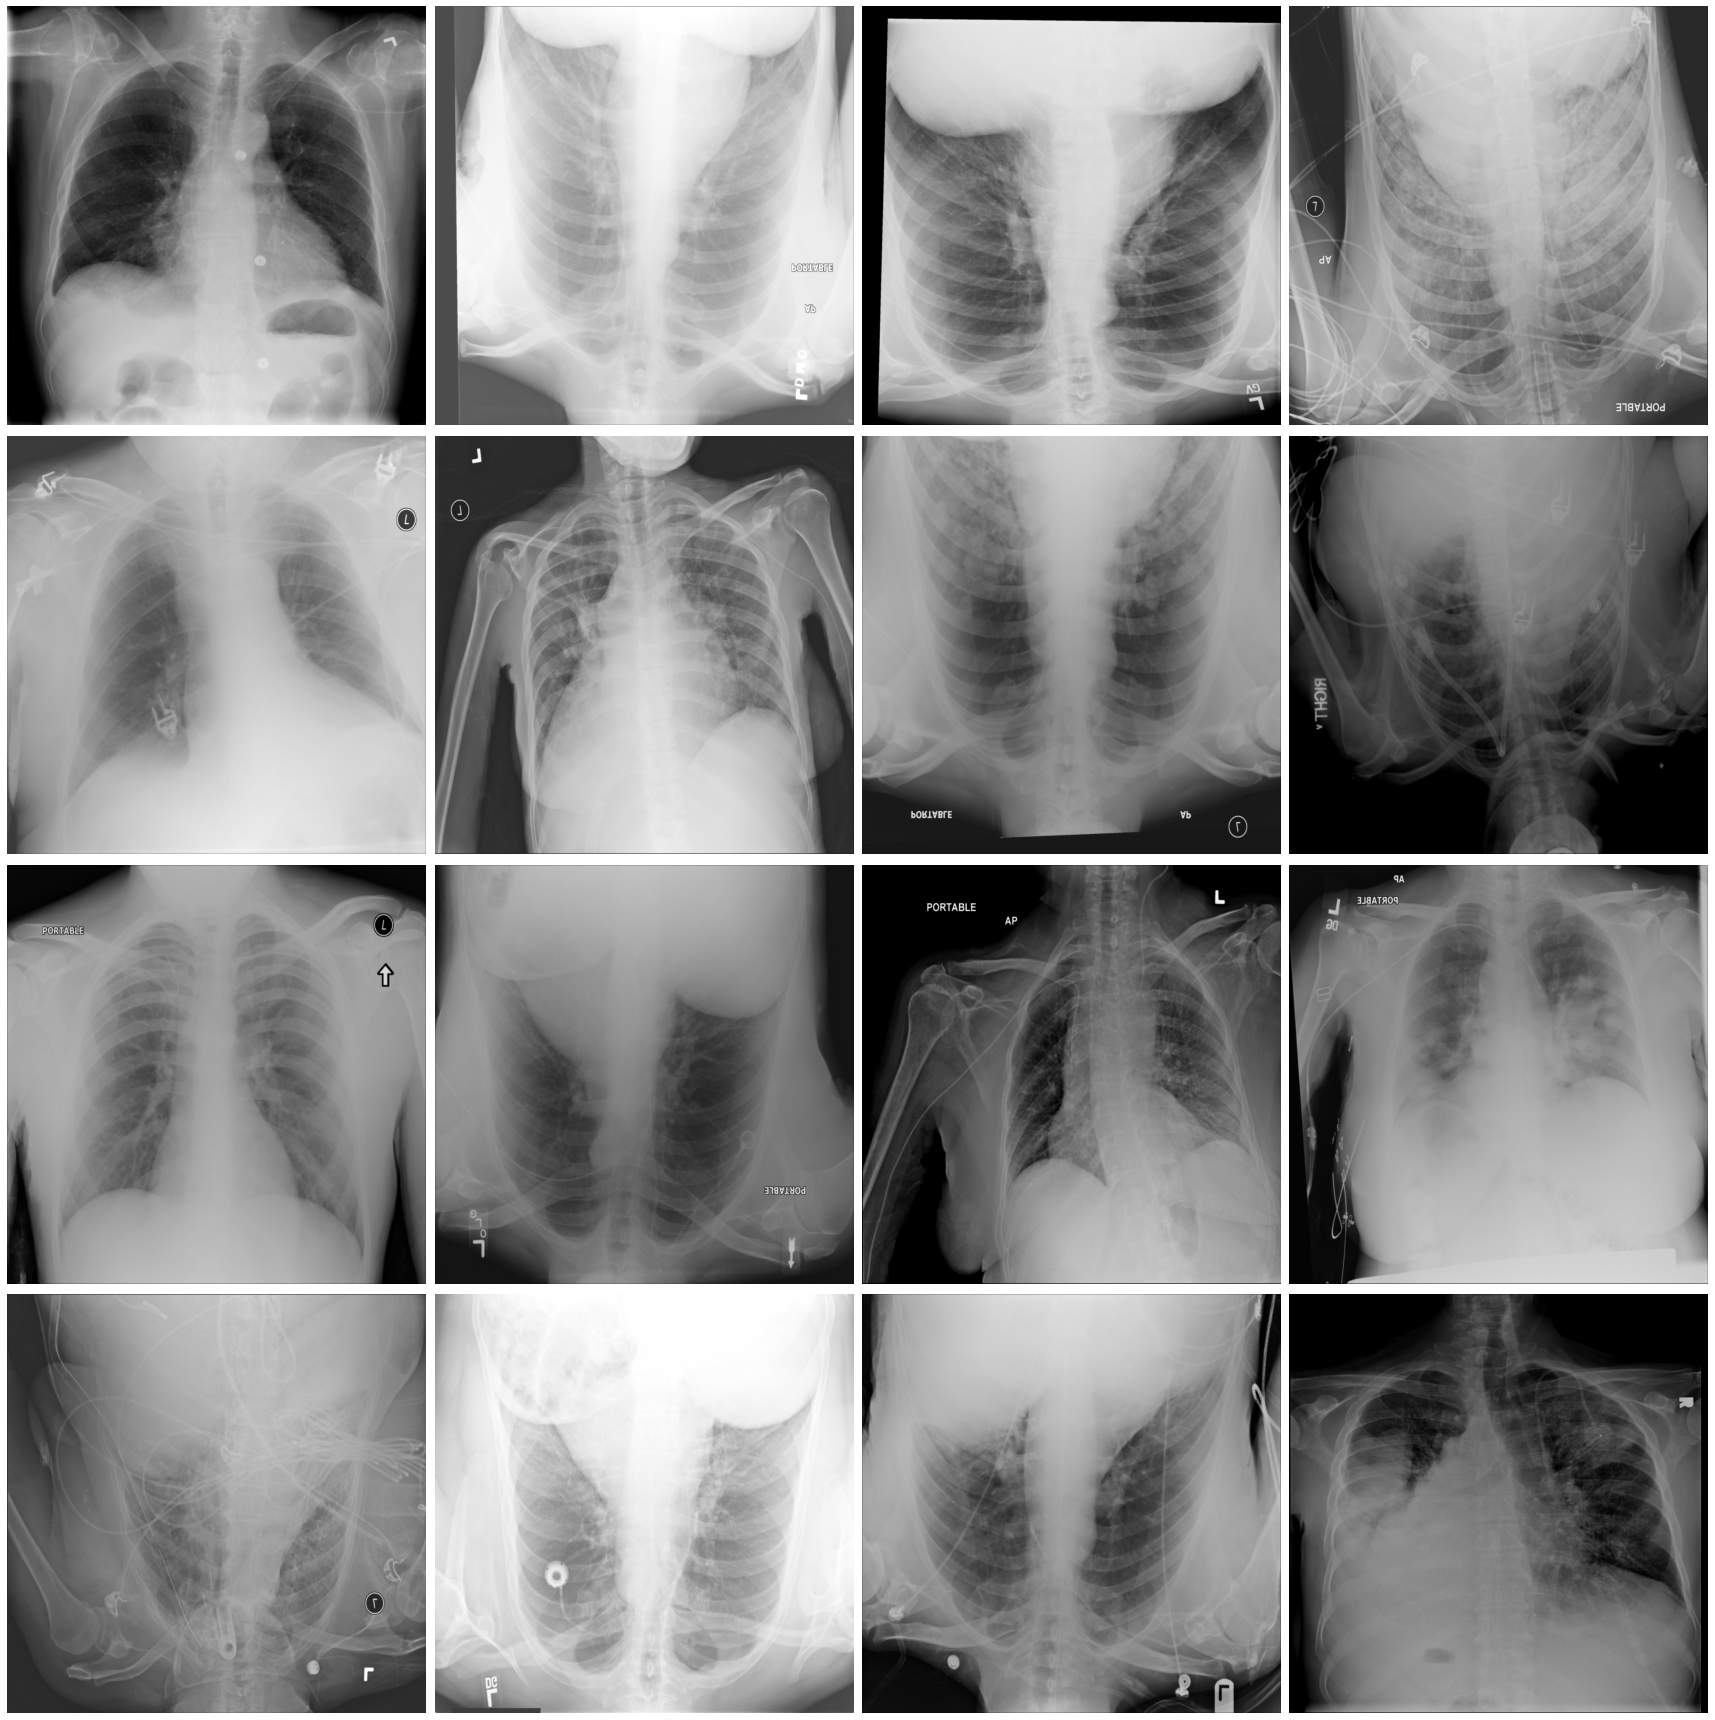

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(24,24))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
with strategy.scope():
    net = tf.keras.applications.ResNet50(include_top=False,input_shape=(img_size, img_size, 3), weights='imagenet')
    x = net.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation='sigmoid')(x)
    model = Model(inputs=net.input, outputs=output)
    model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(multi_label=True)])

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 0, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
        
ckp = ModelCheckpoint('model.h5',monitor = 'val_loss',
                      verbose = 0, save_best_only = True, mode = 'min')
        
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, mode = 'min', 
                    restore_best_weights = True, verbose = 0)

In [14]:
steps_per_epoch = train_paths.shape[0] // batch_size

In [15]:
history = model.fit(dtrain,                      
                    validation_data=dvalid,                                       
                    epochs=n_epochs,
                    callbacks=[rlr,es,ckp],
                    steps_per_epoch=steps_per_epoch,
                    verbose=1)

Epoch 1/30
206/206 [==============================] - 1063s 5s/step - loss: 0.2490 - auc: 0.7623 - val_loss: 0.3989 - val_auc: 0.5133 - lr: 0.0010
Epoch 2/30
206/206 [==============================] - 169s 819ms/step - loss: 0.2215 - auc: 0.8060 - val_loss: 0.4228 - val_auc: 0.5111 - lr: 0.0010
Epoch 3/30
206/206 [==============================] - 171s 828ms/step - loss: 0.2118 - auc: 0.8230 - val_loss: 0.6489 - val_auc: 0.4938 - lr: 0.0010
Epoch 4/30
206/206 [==============================] - 175s 848ms/step - loss: 0.1993 - auc: 0.8453 - val_loss: 0.3047 - val_auc: 0.7305 - lr: 1.0000e-04
Epoch 5/30
206/206 [==============================] - 174s 847ms/step - loss: 0.1930 - auc: 0.8597 - val_loss: 0.2206 - val_auc: 0.8320 - lr: 1.0000e-04
Epoch 6/30
206/206 [==============================] - 173s 839ms/step - loss: 0.1872 - auc: 0.8734 - val_loss: 0.2040 - val_auc: 0.8460 - lr: 1.0000e-04
Epoch 7/30
206/206 [==============================] - 174s 843ms/step - loss: 0.1818 - auc: 0.88

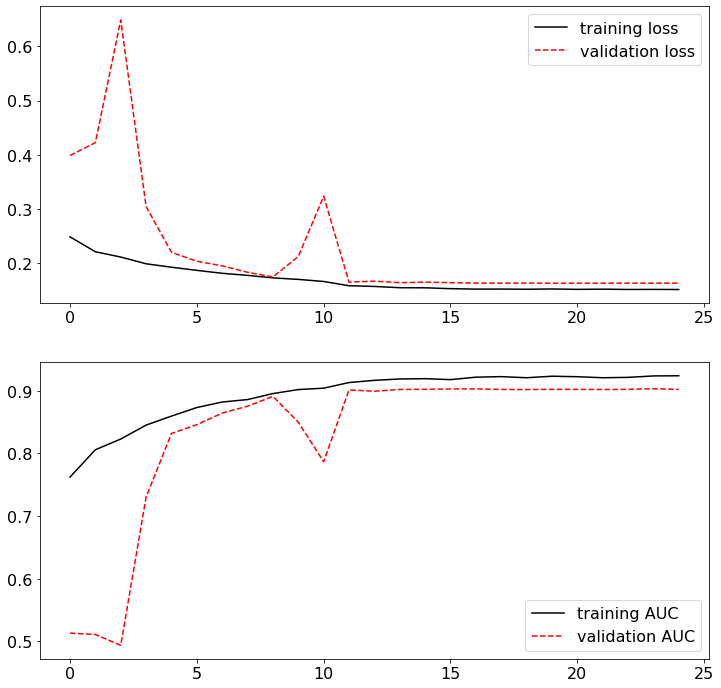

In [16]:
plt.rcParams.update({'font.size': 16})
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist['auc'].plot(ax=ax2,c='k',label='training AUC')
hist['val_auc'].plot(ax=ax2,c='r',linestyle='--',label='validation AUC')
ax2.legend()
plt.show()